In [19]:
# ============================================================================
# CELL 1: Install Required Libraries (Run in Google Colab)
# ============================================================================

# !pip install simpletransformers
# !pip install scikit-learn
# !pip install seaborn
# !pip install torch==2.7.1 torchvision==0.22.1 torchaudio==2.7.1 --index-url https://download.pytorch.org/whl/cu118




In [20]:

# ============================================================================
# CELL 2: Import Libraries
# ============================================================================


In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import torch
import warnings
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
warnings.filterwarnings('ignore')

In [22]:

# ============================================================================
# CELL 3: Load Datasets
# ============================================================================


In [23]:
olid_train = pd.read_csv('../assignment_3/Subjectivity_mining_assignment_4_5_data/olid-train-small.csv')
olid_test = pd.read_csv('../assignment_3/Subjectivity_mining_assignment_4_5_data/olid-test.csv')
hasoc_train = pd.read_csv('../assignment_3/Subjectivity_mining_assignment_4_5_data/hasoc-train.csv')

print(f"OLID-train: {len(olid_train)} samples")
print(f"OLID-test: {len(olid_test)} samples")
print(f"HASOC-train: {len(hasoc_train)} samples")

display(olid_train.head(3))
display(olid_test.head(3))
display(hasoc_train.head(3))

OLID-train: 5852 samples
OLID-test: 860 samples
HASOC-train: 5852 samples


,id,text,labels
0,24590,@USER @USER @USER @USER @USER Hahah a left tel...,0
1,19287,@USER @USER I’m glad you do babe (I kiss you b...,0
2,44676,@USER And I have concerns with”Democrats”,0


,id,text,labels
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,1
1,27014,"#ConstitutionDay is revered by Conservatives, ...",0
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,0


,id,text,labels
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,0
1,hasoc_en_2,@politico No. We should remember very clearly ...,1
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,0



OLID-train:
  Class 0 (Non-offensive): 3591 (61.36%)
  Class 1 (Offensive): 2261 (38.64%)

OLID-test:
  Class 0 (Non-offensive): 620 (72.09%)
  Class 1 (Offensive): 240 (27.91%)

HASOC-train:
  Class 0 (Non-offensive): 3591 (61.36%)
  Class 1 (Offensive): 2261 (38.64%)


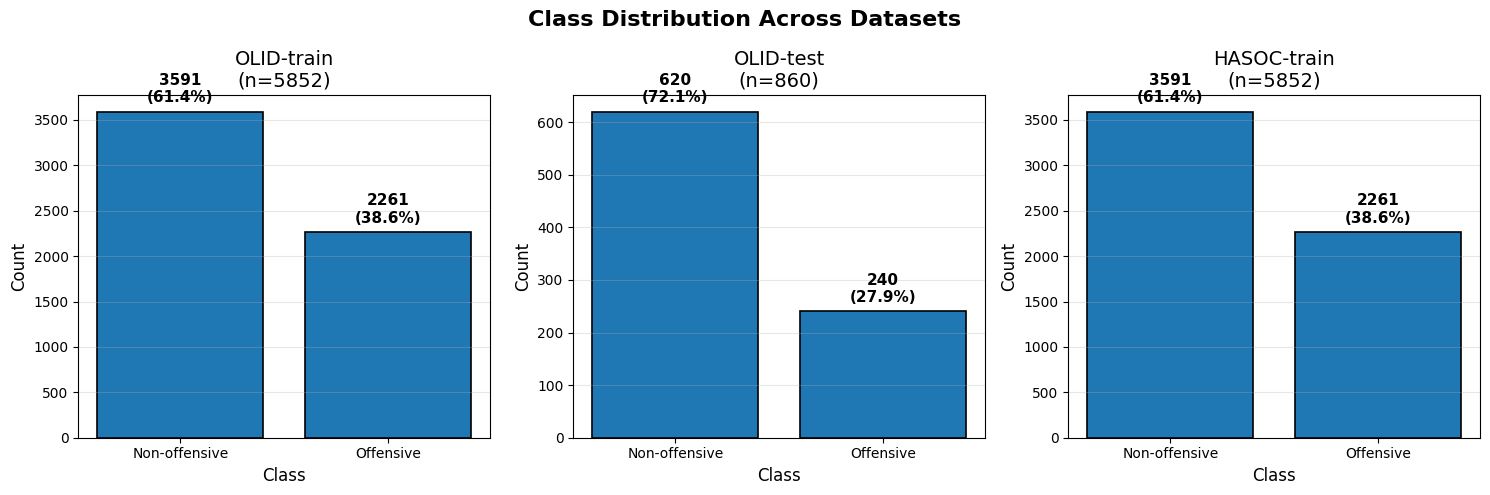


OLID-train:
  Mean: 126.29
  Median: 104
  Std: 85.89
  Range: [10, 560]

OLID-test:
  Mean: 146.11
  Median: 134
  Std: 78.14
  Range: [6, 314]

HASOC-train:
  Mean: 167.04
  Median: 158
  Std: 82.49
  Range: [14, 968]


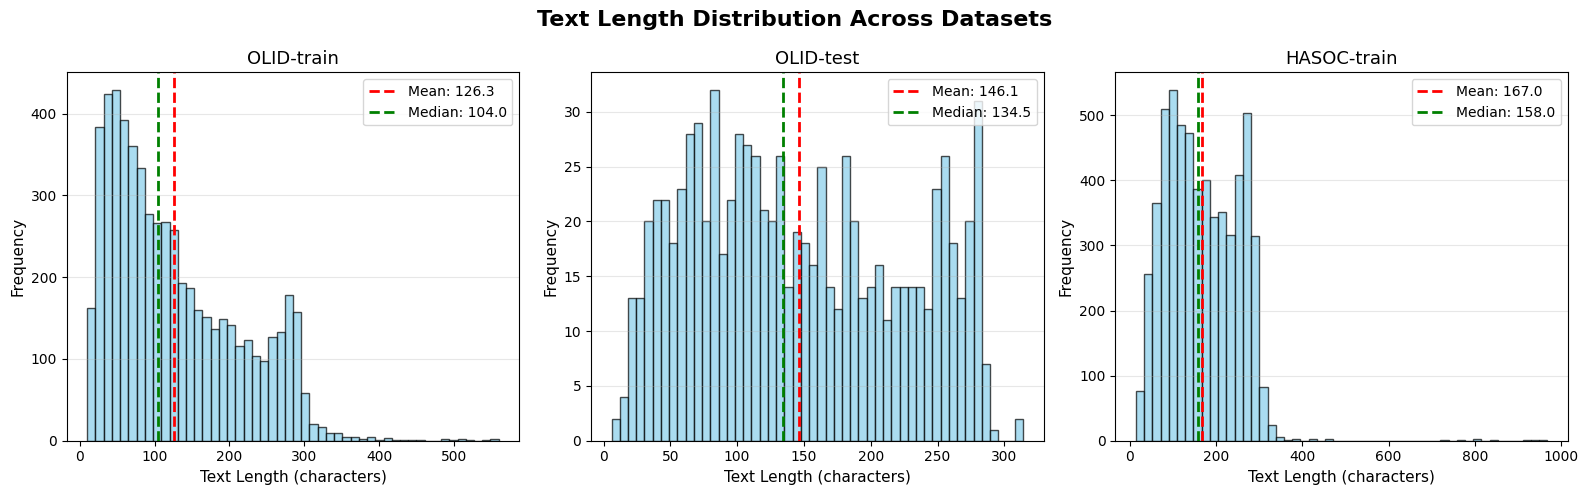


OLID-train: @USER=92.7%, URLs=14.0%, Hashtags=14.2%

OLID-test: @USER=38.5%, URLs=55.9%, Hashtags=73.8%

HASOC-train: @USER=0.0%, URLs=0.0%, Hashtags=98.4%


In [24]:

# ============================================================================
# CELL 4: Dataset Analysis - Class Distribution
# ============================================================================

for name, data in [('OLID-train', olid_train), ('OLID-test', olid_test), ('HASOC-train', hasoc_train)]:
    print(f"\n{name}:")
    dist = data['labels'].value_counts().sort_index()
    for label in [0,1]:
        count = dist.get(label, 0)
        pct = count / len(data) * 100
        label_name = "Non-offensive" if label==0 else "Offensive"
        print(f"  Class {label} ({label_name}): {count} ({pct:.2f}%)")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
datasets = [olid_train, olid_test, hasoc_train]
names = ['OLID-train', 'OLID-test', 'HASOC-train']

for i, (data, name) in enumerate(zip(datasets, names)):
    counts = data['labels'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, edgecolor='black', linewidth=1.2)
    axes[i].set_xlabel('Class', fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].set_title(f'{name}\n(n={len(data)})', fontsize=14)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Non-offensive', 'Offensive'])
    axes[i].grid(axis='y', alpha=0.3)
    
    for j, v in enumerate(counts.values):
        pct = v / len(data) * 100
        axes[i].text(j, v + max(counts.values)*0.02, f'{v}\n({pct:.1f}%)', 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Class Distribution Across Datasets', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# CELL 5: Text Length Analysis
# ============================================================================

for name, data in [('OLID-train', olid_train), ('OLID-test', olid_test), ('HASOC-train', hasoc_train)]:
    lengths = data['text'].str.len()
    print(f"\n{name}:")
    print(f"  Mean: {lengths.mean():.2f}")
    print(f"  Median: {lengths.median():.0f}")
    print(f"  Std: {lengths.std():.2f}")
    print(f"  Range: [{lengths.min():.0f}, {lengths.max():.0f}]")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, (data, name) in enumerate(zip(datasets, names)):
    lengths = data['text'].str.len()
    axes[i].hist(lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].axvline(lengths.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {lengths.mean():.1f}')
    axes[i].axvline(lengths.median(), color='green', linestyle='--', 
                   linewidth=2, label=f'Median: {lengths.median():.1f}')
    axes[i].set_xlabel('Text Length (characters)', fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)
    axes[i].set_title(name, fontsize=13)
    axes[i].legend(fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Text Length Distribution Across Datasets', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
# ============================================================================
# CELL 6: Content Patterns Analysis
# ============================================================================

def analyze_patterns(data):
    patterns = {
        'user_mentions': data['text'].str.contains('@USER').sum(),
        'urls': data['text'].str.contains('URL|http', regex=True).sum(),
        'hashtags': data['text'].str.contains('#\w+', regex=True).sum()
    }
    percentages = {k:v/len(data)*100 for k,v in patterns.items()}
    return patterns, percentages

for name, data in [('OLID-train', olid_train), ('OLID-test', olid_test), ('HASOC-train', hasoc_train)]:
    counts, pcts = analyze_patterns(data)
    print(f"\n{name}: @USER={pcts['user_mentions']:.1f}%, URLs={pcts['urls']:.1f}%, Hashtags={pcts['hashtags']:.1f}%")

In [25]:

# ============================================================================
# CELL 7: Setup Transformer Models
# ============================================================================


In [26]:

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

model_args = ClassificationArgs(
    num_train_epochs=5,
    learning_rate=2e-5,
    train_batch_size=16,
    eval_batch_size=32,
    max_seq_length=128,
    overwrite_output_dir=True,
    reprocess_input_data=True,
    save_model_every_epoch=False,
    silent=True 
)

CUDA available: True


In [27]:

# ============================================================================
# CELL 8: Evaluation Function
# ============================================================================


In [28]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{'='*60}\n{model_name} Results\n{'='*60}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-offensive','Offensive'], digits=4))
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    print(f"\nMacro-averaged Metrics: Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-offensive','Offensive'], yticklabels=['Non-offensive','Offensive'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return precision, recall, f1

# ============================================================================
# BiLSTM Helper Classes and Functions
# ============================================================================

In [29]:
class Tokenizer:
    """Simple PyTorch-based tokenizer"""
    def __init__(self, max_words=10000, oov_token='<OOV>'):
        self.max_words = max_words
        self.oov_token = oov_token
        self.word_index = {oov_token: 1, '<PAD>': 0}
        self.index_word = {1: oov_token, 0: '<PAD>'}
        
    def fit_on_texts(self, texts):
        word_counts = Counter()
        for text in texts:
            words = text.lower().split()
            word_counts.update(words)
        
        most_common = word_counts.most_common(self.max_words - 2)
        for idx, (word, _) in enumerate(most_common, start=2):
            self.word_index[word] = idx
            self.index_word[idx] = word
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            words = text.lower().split()
            sequence = [self.word_index.get(word, 1) for word in words]
            sequences.append(sequence)
        return sequences

def pad_sequences(sequences, maxlen=100, padding='post', truncating='post', value=0):
    padded = []
    for seq in sequences:
        if len(seq) > maxlen:
            if truncating == 'post':
                seq = seq[:maxlen]
            else:
                seq = seq[-maxlen:]
        else:
            if padding == 'post':
                seq = seq + [value] * (maxlen - len(seq))
            else:
                seq = [value] * (maxlen - len(seq)) + seq
        padded.append(seq)
    return np.array(padded)

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, num_layers=2, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                           bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, 2)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.fc(self.dropout(hidden_concat))
        return output

class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def prepare_bilstm_data(train_texts, test_texts, max_words=10000, max_len=100):
    tokenizer = Tokenizer(max_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    test_sequences = tokenizer.texts_to_sequences(test_texts)
    
    train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
    test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
    
    return train_padded, test_padded, tokenizer

In [30]:
# Split training data for hyperparameter tuning
from sklearn.model_selection import train_test_split

olid_train_split, olid_val = train_test_split(
    olid_train, 
    test_size=0.2, 
    random_state=42,
    stratify=olid_train['labels']
)

hasoc_train_split, hasoc_val = train_test_split(
    hasoc_train,
    test_size=0.2,
    random_state=42,
    stratify=hasoc_train['labels']
)

# Then tune hyperparameters on validation set before final test evaluation

### BILSTM trainier & Evaluater

In [31]:
def train_bilstm(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        
        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

def evaluate_bilstm(model, test_loader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for sequences, _ in test_loader:
            sequences = sequences.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    return np.array(predictions)

# ============================================================================
# CELL 9-16: Transformers In-domain & Cross-domain
# ============================================================================

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERT In-domain (OLID→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.8932    0.8500    0.8711       620
    Offensive     0.6556    0.7375    0.6941       240

     accuracy                         0.8186       860
    macro avg     0.7744    0.7937    0.7826       860
 weighted avg     0.8269    0.8186    0.8217       860


Macro-averaged Metrics: Precision=0.7744, Recall=0.7937, F1-Score=0.7826

Confusion Matrix:
 [[527  93]
 [ 63 177]]


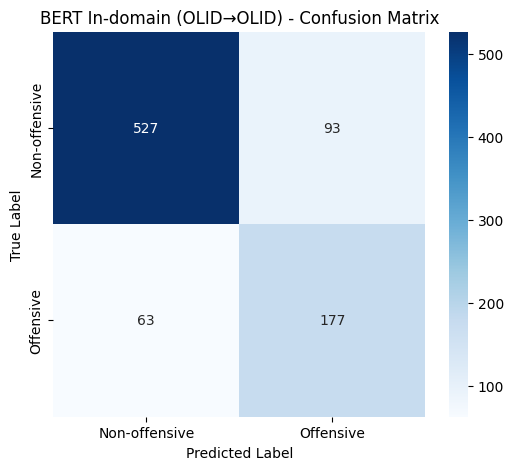


BERT Cross-domain (HASOC→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.8392    0.8500    0.8446       620
    Offensive     0.5991    0.5792    0.5890       240

     accuracy                         0.7744       860
    macro avg     0.7192    0.7146    0.7168       860
 weighted avg     0.7722    0.7744    0.7732       860


Macro-averaged Metrics: Precision=0.7192, Recall=0.7146, F1-Score=0.7168

Confusion Matrix:
 [[527  93]
 [101 139]]


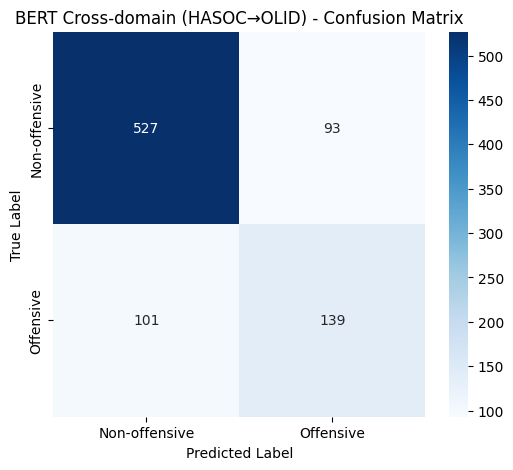

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



RoBERTa In-domain (OLID→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.8831    0.8774    0.8803       620
    Offensive     0.6885    0.7000    0.6942       240

     accuracy                         0.8279       860
    macro avg     0.7858    0.7887    0.7872       860
 weighted avg     0.8288    0.8279    0.8283       860


Macro-averaged Metrics: Precision=0.7858, Recall=0.7887, F1-Score=0.7872

Confusion Matrix:
 [[544  76]
 [ 72 168]]


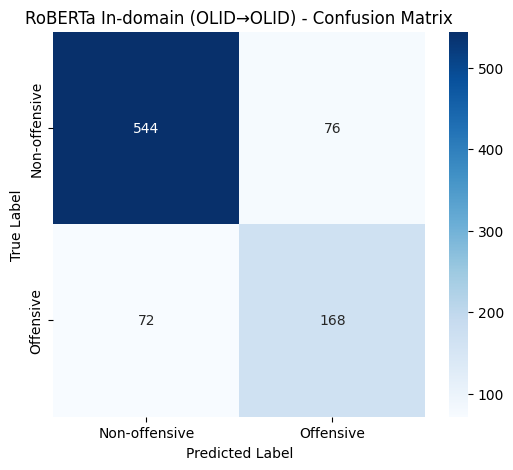


RoBERTa Cross-domain (HASOC→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.8729    0.8419    0.8571       620
    Offensive     0.6260    0.6833    0.6534       240

     accuracy                         0.7977       860
    macro avg     0.7494    0.7626    0.7553       860
 weighted avg     0.8040    0.7977    0.8003       860


Macro-averaged Metrics: Precision=0.7494, Recall=0.7626, F1-Score=0.7553

Confusion Matrix:
 [[522  98]
 [ 76 164]]


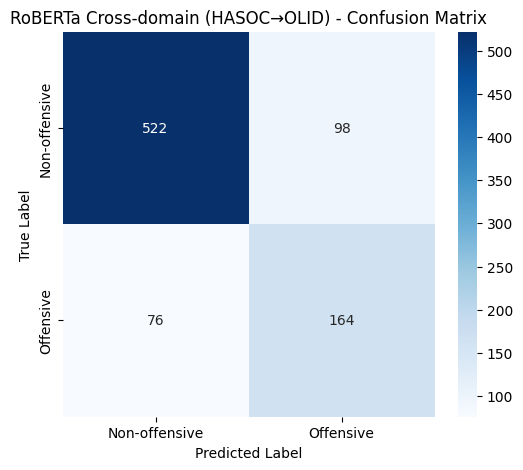

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



HateBERT In-domain (OLID→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.8707    0.8903    0.8804       620
    Offensive     0.6991    0.6583    0.6781       240

     accuracy                         0.8256       860
    macro avg     0.7849    0.7743    0.7792       860
 weighted avg     0.8228    0.8256    0.8239       860


Macro-averaged Metrics: Precision=0.7849, Recall=0.7743, F1-Score=0.7792

Confusion Matrix:
 [[552  68]
 [ 82 158]]


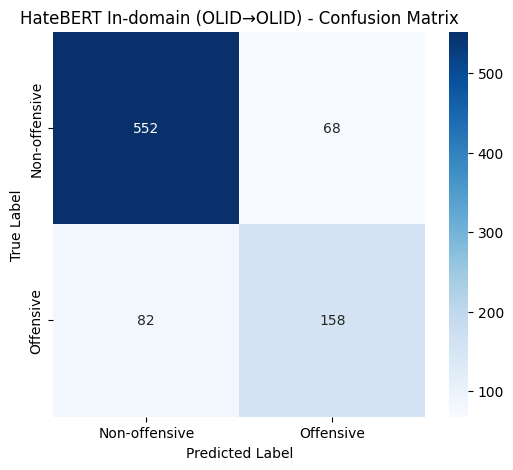


HateBERT Cross-domain (HASOC→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.8468    0.8645    0.8555       620
    Offensive     0.6300    0.5958    0.6124       240

     accuracy                         0.7895       860
    macro avg     0.7384    0.7302    0.7340       860
 weighted avg     0.7863    0.7895    0.7877       860


Macro-averaged Metrics: Precision=0.7384, Recall=0.7302, F1-Score=0.7340

Confusion Matrix:
 [[536  84]
 [ 97 143]]


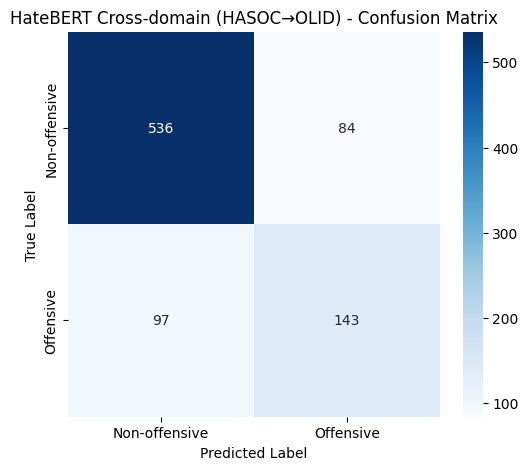

In [32]:
def train_transformer(model_type, model_name, train_df, test_texts, model_args, cuda_available):
    model = ClassificationModel(model_type, model_name, num_labels=2, args=model_args, use_cuda=cuda_available)
    model.train_model(train_df)
    preds, _ = model.predict(test_texts)
    return model, preds

train_df_olid = olid_train[['text','labels']].copy()
test_texts_olid = olid_test['text'].tolist()
train_df_hasoc = hasoc_train[['text','labels']].copy()

# BERT
bert_olid_model, predictions_bert_indomain = train_transformer('bert','bert-base-uncased',train_df_olid,test_texts_olid,model_args,cuda_available)
bert_cross_model, predictions_bert_cross = train_transformer('bert','bert-base-uncased',train_df_hasoc,test_texts_olid,model_args,cuda_available)

bert_indomain_results = evaluate_model(olid_test['labels'].values, predictions_bert_indomain, "BERT In-domain (OLID→OLID)")
bert_crossdomain_results = evaluate_model(olid_test['labels'].values, predictions_bert_cross, "BERT Cross-domain (HASOC→OLID)")

# RoBERTa
roberta_olid_model, predictions_roberta_indomain = train_transformer('roberta','roberta-base',train_df_olid,test_texts_olid,model_args,cuda_available)
roberta_cross_model, predictions_roberta_cross = train_transformer('roberta','roberta-base',train_df_hasoc,test_texts_olid,model_args,cuda_available)

roberta_indomain_results = evaluate_model(olid_test['labels'].values, predictions_roberta_indomain, "RoBERTa In-domain (OLID→OLID)")
roberta_crossdomain_results = evaluate_model(olid_test['labels'].values, predictions_roberta_cross, "RoBERTa Cross-domain (HASOC→OLID)")

# HateBERT
hatebert_olid_model, predictions_hatebert_indomain = train_transformer('bert','GroNLP/hateBERT',train_df_olid,test_texts_olid,model_args,cuda_available)
hatebert_cross_model, predictions_hatebert_cross = train_transformer('bert','GroNLP/hateBERT',train_df_hasoc,test_texts_olid,model_args,cuda_available)

hatebert_indomain_results = evaluate_model(olid_test['labels'].values, predictions_hatebert_indomain, "HateBERT In-domain (OLID→OLID)")
hatebert_crossdomain_results = evaluate_model(olid_test['labels'].values, predictions_hatebert_cross, "HateBERT Cross-domain (HASOC→OLID)")

# ============================================================================
# CELL 16: BiLSTM In-domain (OLID→OLID)
# =====================================

Using device: cuda
Training BiLSTM In-domain (OLID → OLID)...
Epoch 2/10, Loss: 0.6398, Accuracy: 63.55%
Epoch 4/10, Loss: 0.5467, Accuracy: 72.37%
Epoch 6/10, Loss: 0.4345, Accuracy: 80.47%
Epoch 8/10, Loss: 0.3594, Accuracy: 84.95%
Epoch 10/10, Loss: 0.2535, Accuracy: 89.61%

BiLSTM In-domain (OLID→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.7958    0.8548    0.8243       620
    Offensive     0.5361    0.4333    0.4793       240

     accuracy                         0.7372       860
    macro avg     0.6659    0.6441    0.6518       860
 weighted avg     0.7233    0.7372    0.7280       860


Macro-averaged Metrics: Precision=0.6659, Recall=0.6441, F1-Score=0.6518

Confusion Matrix:
 [[530  90]
 [136 104]]


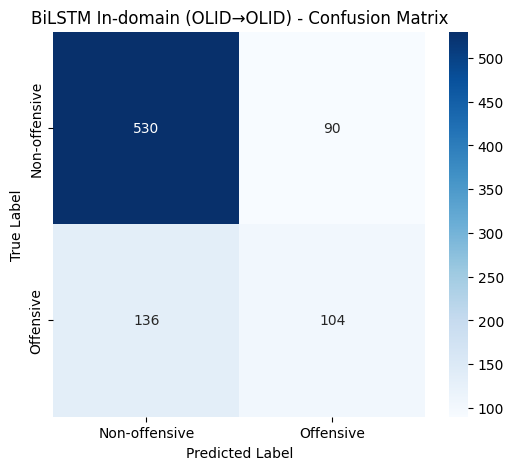

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_padded_olid, test_padded_olid, tokenizer_olid = prepare_bilstm_data(
    olid_train['text'].tolist(),
    olid_test['text'].tolist(),
    max_words=10000,
    max_len=100
)

train_dataset_olid = TextDataset(train_padded_olid, olid_train['labels'].values)
test_dataset_olid = TextDataset(test_padded_olid, olid_test['labels'].values)

train_loader_olid = DataLoader(train_dataset_olid, batch_size=32, shuffle=True)
test_loader_olid = DataLoader(test_dataset_olid, batch_size=32, shuffle=False)

vocab_size_olid = len(tokenizer_olid.word_index)
bilstm_model_indomain = BiLSTMClassifier(
    vocab_size=vocab_size_olid,
    embedding_dim=100,
    hidden_dim=128,
    num_layers=2,
    dropout=0.3
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_model_indomain.parameters(), lr=0.001)

print("Training BiLSTM In-domain (OLID → OLID)...")
train_bilstm(bilstm_model_indomain, train_loader_olid, criterion, optimizer, device, epochs=10)

bilstm_predictions_indomain = evaluate_bilstm(bilstm_model_indomain, test_loader_olid, device)
bilstm_indomain_results = evaluate_model(olid_test['labels'].values, bilstm_predictions_indomain, "BiLSTM In-domain (OLID→OLID)")


Training BiLSTM Cross-domain (HASOC → OLID)...
Epoch 2/10, Loss: 0.6343, Accuracy: 63.36%
Epoch 4/10, Loss: 0.5551, Accuracy: 71.24%
Epoch 6/10, Loss: 0.4479, Accuracy: 78.55%
Epoch 8/10, Loss: 0.3659, Accuracy: 83.60%
Epoch 10/10, Loss: 0.2753, Accuracy: 88.76%

BiLSTM Cross-domain (HASOC→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.7361    0.5532    0.6317       620
    Offensive     0.2970    0.4875    0.3691       240

     accuracy                         0.5349       860
    macro avg     0.5165    0.5204    0.5004       860
 weighted avg     0.6135    0.5349    0.5584       860


Macro-averaged Metrics: Precision=0.5165, Recall=0.5204, F1-Score=0.5004

Confusion Matrix:
 [[343 277]
 [123 117]]


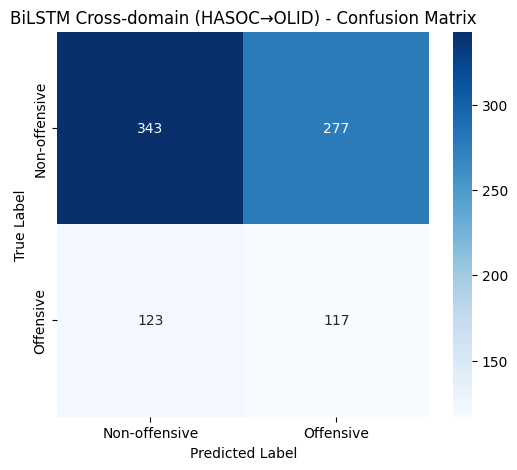

In [34]:

# ============================================================================
# CELL 17: BiLSTM Cross-domain (HASOC→OLID)
# ============================================================================

train_padded_hasoc, test_padded_hasoc, tokenizer_hasoc = prepare_bilstm_data(
    hasoc_train['text'].tolist(),
    olid_test['text'].tolist(),
    max_words=10000,
    max_len=100
)

train_dataset_hasoc = TextDataset(train_padded_hasoc, hasoc_train['labels'].values)
test_dataset_hasoc = TextDataset(test_padded_hasoc, olid_test['labels'].values)

train_loader_hasoc = DataLoader(train_dataset_hasoc, batch_size=32, shuffle=True)
test_loader_hasoc = DataLoader(test_dataset_hasoc, batch_size=32, shuffle=False)

vocab_size_hasoc = len(tokenizer_hasoc.word_index)
bilstm_model_cross = BiLSTMClassifier(
    vocab_size=vocab_size_hasoc,
    embedding_dim=100,
    hidden_dim=128,
    num_layers=2,
    dropout=0.3
).to(device)

optimizer_cross = torch.optim.Adam(bilstm_model_cross.parameters(), lr=0.001)

print("Training BiLSTM Cross-domain (HASOC → OLID)...")
train_bilstm(bilstm_model_cross, train_loader_hasoc, criterion, optimizer_cross, device, epochs=10)

bilstm_predictions_cross = evaluate_bilstm(bilstm_model_cross, test_loader_hasoc, device)
bilstm_crossdomain_results = evaluate_model(olid_test['labels'].values, bilstm_predictions_cross, "BiLSTM Cross-domain (HASOC→OLID)")

# ============================================================================
# CELL 17-22: Classical ML Models
# ============================================================================


SVM In-domain (OLID→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.8219    0.9081    0.8628       620
    Offensive     0.6743    0.4917    0.5687       240

     accuracy                         0.7919       860
    macro avg     0.7481    0.6999    0.7158       860
 weighted avg     0.7807    0.7919    0.7807       860


Macro-averaged Metrics: Precision=0.7481, Recall=0.6999, F1-Score=0.7158

Confusion Matrix:
 [[563  57]
 [122 118]]


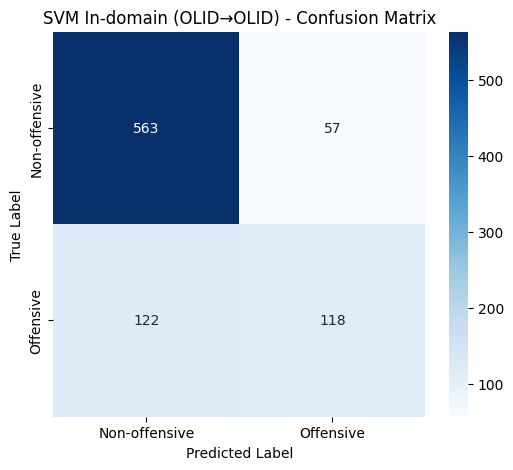


SVM Cross-domain (HASOC→OLID) Results

Classification Report:
               precision    recall  f1-score   support

Non-offensive     0.7759    0.7371    0.7560       620
    Offensive     0.3985    0.4500    0.4227       240

     accuracy                         0.6570       860
    macro avg     0.5872    0.5935    0.5893       860
 weighted avg     0.6706    0.6570    0.6630       860


Macro-averaged Metrics: Precision=0.5872, Recall=0.5935, F1-Score=0.5893

Confusion Matrix:
 [[457 163]
 [132 108]]


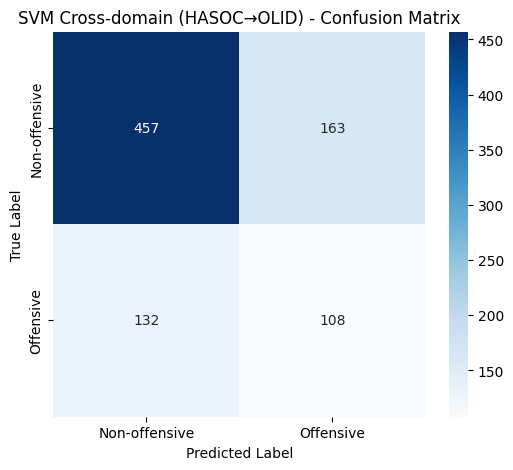

In [35]:
# ============================================================================
# CELL 18: SVM In-domain (OLID→OLID)
# ============================================================================



# TF-IDF
tfidf_olid = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_olid = tfidf_olid.fit_transform(olid_train['text'])
X_test_olid = tfidf_olid.transform(olid_test['text'])

# SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_olid, olid_train['labels'])
svm_predictions_indomain = svm_model.predict(X_test_olid)
svm_indomain_results = evaluate_model(olid_test['labels'].values, svm_predictions_indomain, "SVM In-domain (OLID→OLID)")


# ============================================================================
# CELL 19: SVM Cross-domain (HASOC→OLID)
# ============================================================================

tfidf_hasoc = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_hasoc = tfidf_hasoc.fit_transform(hasoc_train['text'])
X_test_hasoc = tfidf_hasoc.transform(olid_test['text'])

svm_cross = SVC(kernel='linear', random_state=42)
svm_cross.fit(X_train_hasoc, hasoc_train['labels'])
svm_predictions_cross = svm_cross.predict(X_test_hasoc)
svm_crossdomain_results = evaluate_model(olid_test['labels'].values, svm_predictions_cross, "SVM Cross-domain (HASOC→OLID)")


# ============================================================================
# CELL 28: Results Summary
# ============================================================================

In [36]:
results_summary_extended = pd.DataFrame([
    {'Model':'BERT','Setup':'In-domain','Precision':bert_indomain_results[0],'Recall':bert_indomain_results[1],'F1-Score':bert_indomain_results[2]},
    {'Model':'BERT','Setup':'Cross-domain','Precision':bert_crossdomain_results[0],'Recall':bert_crossdomain_results[1],'F1-Score':bert_crossdomain_results[2]},
    {'Model':'RoBERTa','Setup':'In-domain','Precision':roberta_indomain_results[0],'Recall':roberta_indomain_results[1],'F1-Score':roberta_indomain_results[2]},
    {'Model':'RoBERTa','Setup':'Cross-domain','Precision':roberta_crossdomain_results[0],'Recall':roberta_crossdomain_results[1],'F1-Score':roberta_crossdomain_results[2]},
    {'Model':'HateBERT','Setup':'In-domain','Precision':hatebert_indomain_results[0],'Recall':hatebert_indomain_results[1],'F1-Score':hatebert_indomain_results[2]},
    {'Model':'HateBERT','Setup':'Cross-domain','Precision':hatebert_crossdomain_results[0],'Recall':hatebert_crossdomain_results[1],'F1-Score':hatebert_crossdomain_results[2]},
    {'Model':'BiLSTM','Setup':'In-domain','Precision':bilstm_indomain_results[0],'Recall':bilstm_indomain_results[1],'F1-Score':bilstm_indomain_results[2]},
    {'Model':'BiLSTM','Setup':'Cross-domain','Precision':bilstm_crossdomain_results[0],'Recall':bilstm_crossdomain_results[1],'F1-Score':bilstm_crossdomain_results[2]},
    {'Model':'SVM','Setup':'In-domain','Precision':svm_indomain_results[0],'Recall':svm_indomain_results[1],'F1-Score':svm_indomain_results[2]},
    {'Model':'SVM','Setup':'Cross-domain','Precision':svm_crossdomain_results[0],'Recall':svm_crossdomain_results[1],'F1-Score':svm_crossdomain_results[2]},
])

print(results_summary_extended)
results_summary_extended.to_csv('model_results_summary_extended.csv', index=False)


      Model         Setup  Precision    Recall  F1-Score
0      BERT     In-domain   0.774388  0.793750  0.782596
1      BERT  Cross-domain   0.719155  0.714583  0.716767
2   RoBERTa     In-domain   0.785821  0.788710  0.787237
3   RoBERTa  Cross-domain   0.749432  0.762634  0.755265
4  HateBERT     In-domain   0.784889  0.774328  0.779247
5  HateBERT  Cross-domain   0.738359  0.730175  0.733983
6    BiLSTM     In-domain   0.665939  0.644086  0.651762
7    BiLSTM  Cross-domain   0.516503  0.520363  0.500381
8       SVM     In-domain   0.748092  0.699866  0.715755
9       SVM  Cross-domain   0.587208  0.593548  0.589349


# ============================================================================
# CELL 29: Visualize Extended Performance
# ============================================================================


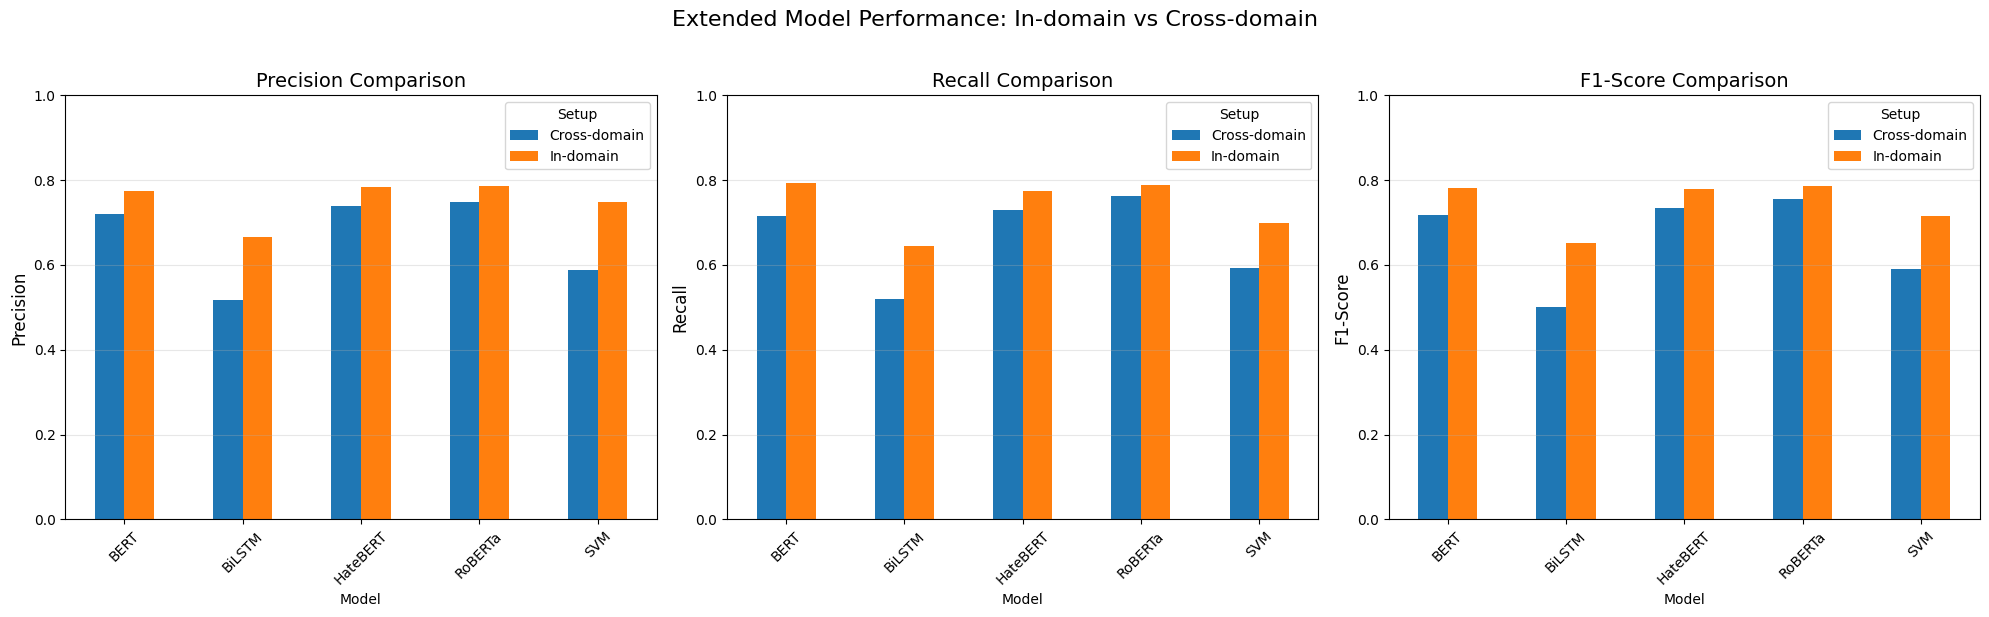

In [37]:
fig, axes = plt.subplots(1,3,figsize=(20,6))
metrics = ['Precision','Recall','F1-Score']

for idx, metric in enumerate(metrics):
    pivot_data = results_summary_extended.pivot(index='Model', columns='Setup', values=metric)
    pivot_data.plot(kind='bar', ax=axes[idx], rot=45)
    axes[idx].set_title(f'{metric} Comparison', fontsize=14)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].legend(title='Setup', fontsize=10)
    axes[idx].set_ylim(0,1)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Extended Model Performance: In-domain vs Cross-domain', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# CELL 30: Performance Drop Analysis
# ============================================================================

Performance Drop Analysis (In-domain → Cross-domain)
BERT: F1 Drop=0.0658 (8.41%)
RoBERTa: F1 Drop=0.0320 (4.06%)
HateBERT: F1 Drop=0.0453 (5.81%)
BiLSTM: F1 Drop=0.1514 (23.23%)
SVM: F1 Drop=0.1264 (17.66%)


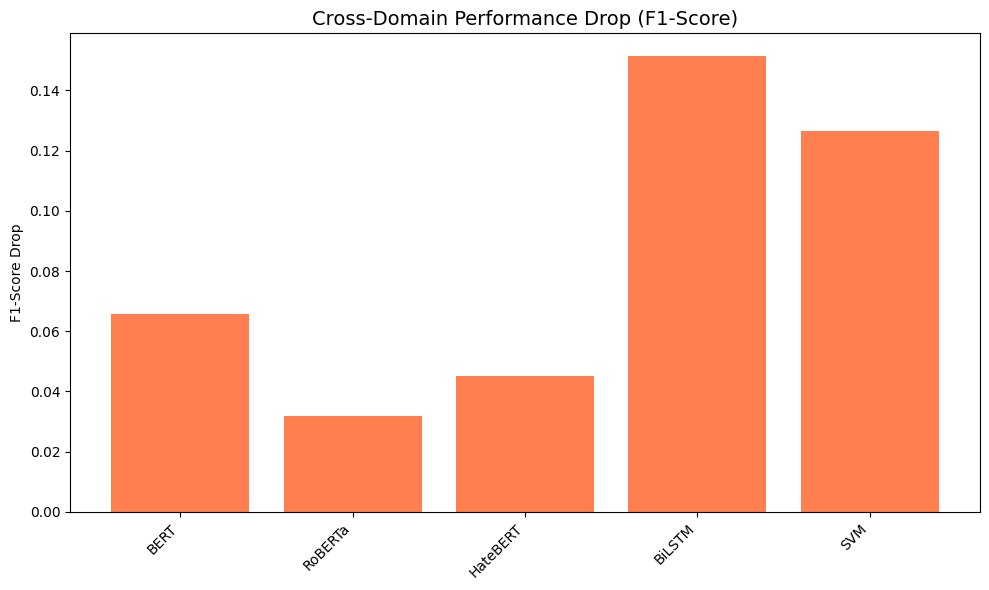

In [38]:
print("Performance Drop Analysis (In-domain → Cross-domain)")
for model in results_summary_extended['Model'].unique():
    in_domain = results_summary_extended[(results_summary_extended['Model']==model)&(results_summary_extended['Setup']=='In-domain')]
    cross_domain = results_summary_extended[(results_summary_extended['Model']==model)&(results_summary_extended['Setup']=='Cross-domain')]
    f1_drop = in_domain['F1-Score'].values[0]-cross_domain['F1-Score'].values[0]
    f1_drop_pct = f1_drop/in_domain['F1-Score'].values[0]*100
    print(f"{model}: F1 Drop={f1_drop:.4f} ({f1_drop_pct:.2f}%)")

drops = []
for model in results_summary_extended['Model'].unique():
    in_f1 = results_summary_extended[(results_summary_extended['Model']==model)&
                                     (results_summary_extended['Setup']=='In-domain')]['F1-Score'].values[0]
    cross_f1 = results_summary_extended[(results_summary_extended['Model']==model)&
                                        (results_summary_extended['Setup']=='Cross-domain')]['F1-Score'].values[0]
    drops.append({'Model': model, 'Drop': in_f1 - cross_f1})

drop_df = pd.DataFrame(drops)
plt.figure(figsize=(10,6))
plt.bar(drop_df['Model'], drop_df['Drop'], color='coral')
plt.xticks(rotation=45, ha='right')
plt.title('Cross-Domain Performance Drop (F1-Score)', fontsize=14)
plt.ylabel('F1-Score Drop')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# ============================================================================
# CELL 31: Error Analysis for Transformers & Random Forest
# ============================================================================

In [39]:
all_models_predictions = {
    'BERT_In': predictions_bert_indomain,
    'BERT_Cross': predictions_bert_cross,
    'RoBERTa_In': predictions_roberta_indomain,
    'RoBERTa_Cross': predictions_roberta_cross,
    'HateBERT_In': predictions_hatebert_indomain,
    'HateBERT_Cross': predictions_hatebert_cross,
    'BiLSTM_In': bilstm_predictions_indomain,
    'BiLSTM_Cross': bilstm_predictions_cross,
    'SVM_In': svm_predictions_indomain,
    'SVM_Cross': svm_predictions_cross
}

def full_error_analysis(model_name, y_true, y_pred, df_texts):
    df = df_texts.copy()
    df['pred'] = y_pred
    df['correct'] = df['labels'] == df['pred']
    
    total_errors = (~df['correct']).sum()
    error_pct = total_errors / len(df) * 100
    print(f"\n{'='*60}\nModel: {model_name}\nTotal Errors: {total_errors}/{len(df)} ({error_pct:.2f}%)\n{'='*60}")
    
    print("\nSample Misclassifications:")
    for idx,row in df[~df['correct']].head(5).iterrows():
        print(f"\nText: {row['text']}\nTrue Label: {row['labels']}, Predicted: {row['pred']}")
    
    df['has_user'] = df['text'].str.contains('@USER')
    df['has_url'] = df['text'].str.contains('URL|http', regex=True)
    df['has_hashtag'] = df['text'].str.contains('#\w+', regex=True)
    df['text_length'] = df['text'].str.len()
    
    for feature in ['has_user','has_url','has_hashtag']:
        with_feature = df[df[feature]]
        without_feature = df[~df[feature]]
        if len(with_feature) > 0:
            rate_with = (~with_feature['correct']).sum()/len(with_feature)*100
            rate_without = (~without_feature['correct']).sum()/len(without_feature)*100
            print(f"{feature.upper()}: With={rate_with:.2f}%, Without={rate_without:.2f}%")
    
    df['length_category'] = pd.cut(df['text_length'], bins=[0,100,150,300], labels=['Short','Medium','Long'])
    for category in df['length_category'].cat.categories:
        subset = df[df['length_category']==category]
        if len(subset)>0:
            err_rate = (~subset['correct']).sum()/len(subset)*100
            print(f"{category}: {len(subset)} samples, Error Rate={err_rate:.2f}%")

for model_name, y_pred in all_models_predictions.items():
    full_error_analysis(model_name, olid_test['labels'].values, y_pred, olid_test)



Model: BERT_In
Total Errors: 156/860 (18.14%)

Sample Misclassifications:

Text: #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendment #RNC #USMC #veterans @USER    @USER @USER @USER @USER   #fakereporting #THESWAMP #dnc #liberals @USER @USER #fakeoutrage @USER  First, it reduces the ca URL
True Label: 0, Predicted: 1

Text: #NoPasaran: Unity demo to oppose the far-right in #London – #antifa #Oct13 — Enough is Enough! URL
True Label: 1, Predicted: 0

Text: #RAP is a form of ART! Used to express yourself freely. It does not gv the green light or excuse the behavior of acting like an animal! She is not in the streets of the BX where violence is a way of living. Elevate yourself boo and get on @USER level for longevity! #QUEEN👑
True Label: 0, Predicted: 1

Text: #ConsTOO THE PLACE FOR FED UP CONSERVATIVES !!!
True Label: 0, Predicted: 1

Text: Always smack URL
True Label: 0, Predicted: 1
HAS_USER: With=21.15%, Without=16.26%
HAS_URL: With=17.88%, Without=18.47%
HAS_HASHTAG: With=19.37%, Withou

# ============================================================================
# CELL 31: Save Transformer Weights
# ============================================================================

In [40]:
bert_olid_model.save_model('bert_olid_model')
bert_cross_model.save_model('bert_cross_model')
roberta_olid_model.save_model('roberta_olid_model')
roberta_cross_model.save_model('roberta_cross_model')
hatebert_olid_model.save_model('hatebert_olid_model')
hatebert_cross_model.save_model('hatebert_cross_model')

torch.save(bilstm_model_indomain.state_dict(), 'bilstm_indomain_model.pth')
torch.save(bilstm_model_cross.state_dict(), 'bilstm_crossdomain_model.pth')

import joblib
joblib.dump(svm_model,'svm_indomain_model.pkl')
joblib.dump(svm_cross,'svm_crossdomain_model.pkl')

import pickle
with open('tokenizer_olid.pkl', 'wb') as f:
    pickle.dump(tokenizer_olid, f)
with open('tokenizer_hasoc.pkl', 'wb') as f:
    pickle.dump(tokenizer_hasoc, f)
